# Solving HJB equation (24) in HS_notes_53

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.matrices import *
from sympy.solvers import solve
from sympy import Symbol
import scipy
from scipy.optimize import minimize
%matplotlib inline

### 7.1 Parametric Inputs

The VAR estimates imply:
$$\hat \alpha_y = 0.386, \hat \alpha_z = 0, \hat \beta = 1, \hat \kappa = 0.019, \sigma_y = \begin{bmatrix} 0.488 \\ 0\end{bmatrix}, \sigma_z = \begin{bmatrix} 0.013 \\ 0.028\end{bmatrix}  $$
We assume that $\delta = 0.002$

Let $\sigma = \begin{bmatrix} \sigma_y' \\ \sigma_z' \end{bmatrix}$

In [3]:
# Input parameter values
alpha_y = 0.386
alpha_z = 0
beta = 1
kappa = 0.019
sigma_y = np.array([[0.488],[0]])
sigma_z = np.array([[0.013],[0.028]])
delta = 0.002
sigma = np.vstack((sigma_y.T,sigma_z.T))

We also need to choose a value for q and $\theta$:

In [4]:
q = 0.05
theta = 0.5

### Step 1: Find $\alpha_z = f(\kappa)$
First we find the boundary of the reference models.
The parametric formula for relative entropy is:

$$ \epsilon(M^R) = \frac{1}{2}|\sigma^{-1} \begin{bmatrix} \alpha_y - \hat \alpha_y \\ \alpha_z - \hat \alpha_z \end{bmatrix}|^2 + \begin{bmatrix} \beta - \hat \beta & \hat \kappa - \kappa \end{bmatrix} (\sigma^{-1})'\sigma^{-1} \begin{bmatrix} \alpha_y - \hat \alpha_y \\ \alpha_z - \hat \alpha_z \end{bmatrix} \frac{\alpha_z}{\kappa} + \frac{1}{2}|\sigma^{-1} \begin{bmatrix} \beta - \hat \beta \\ \hat \kappa - \kappa \end{bmatrix}|^2(\frac{|\sigma_z|^2}{2\kappa} + (\frac{\alpha_z}{\kappa})^2) $$

Letting $\alpha_y = \hat \alpha_y$ and $\beta = \hat \beta = 1$, and setting equal to the boundary, we have:

$$ \epsilon(M^R) = \frac{1}{2}|\sigma^{-1} \begin{bmatrix} 0 \\ \alpha_z - \hat \alpha_z \end{bmatrix}|^2 + \begin{bmatrix} 0 & \hat \kappa - \kappa \end{bmatrix} (\sigma^{-1})'\sigma^{-1} \begin{bmatrix} 0 \\ \alpha_z - \hat \alpha_z \end{bmatrix} \frac{\alpha_z}{\kappa} + \frac{1}{2}|\sigma^{-1} \begin{bmatrix} 0 \\ \hat \kappa - \kappa \end{bmatrix}|^2(\frac{|\sigma_z|^2}{2\kappa} + (\frac{\alpha_z}{\kappa})^2) = \frac{1}{2}q^2 $$

For a given $\kappa$ and q, we use SymPy to find the two values of $\alpha_z$ that solve this equation, and then choose the smaller of the two: $\alpha_z = f(k)$

In [5]:
#Function which finds alpha_z as a function of k

def f(k):
    #Create the vectors:
    x = Symbol('x')
    vec1 = Matrix([[0],[x-alpha_z]])
    vec2 = Matrix([[0],[kappa-k]])

    #Create the components of the equation to be solved for alpha_z
    eq1 = 0.5*(Matrix(sigma).inv()*vec1)[1,0]**2 #using the [1,0] element squared otherwise there is an issue with Abs(x)
    eq2 = vec2.T*Matrix(sigma).inv().T*Matrix(sigma).inv()*vec1*x/k
    eq3 = 0.5*((Matrix(sigma).inv()*vec2).norm()**2)*((Matrix(sigma_z).norm()**2)/(2*k)+(alpha_z/k)**2)

    eq = eq1 + eq2[0,0] + eq3 - 0.5*q**2

    return np.min(solve(eq,x))

In [17]:
f(0.02)

-0.00146673295304754

### Step 2: Find $\mu_z^*(z)$

The next step is to minimize $f(\kappa) - z\kappa$ to find the worst-case reference model $\mu_z^*(z)$.

To do this, I have had to manually work out the bounds over which f(k) is well-defined. 

These bounds depend on q so this is not ideal, I want to find a way to automate.

In [7]:
def mu(z):
    g = lambda k: f(k) - k*z
    k_star = minimize(g,x0=0.02,bounds=((0.0119802,0.03013),)).x[0] #I had to put those bounds on to ensure real solutions
    return f(k_star) - z*k_star

### Step 3: Use $\mu_z^*(z)$ to solve the  HJB equation to find $v(\theta,z)$

The HJB equation is:

$$ 0 = -\delta v(z) + 0.01(\hat \alpha_y + z) + \mu_z^*(z) \frac{dv}{dz}(z) + \frac{1}{2}|\sigma_z|^2 \frac{d^2v}{dz^2}(z) - \frac{1}{2\theta} \begin{bmatrix} 0.01 \, \frac{dv}{dz}(z) \end{bmatrix} \sigma \sigma' \begin{bmatrix} 0.01 \\ \frac{dv}{dz}(z) \end{bmatrix} $$

We want to solve this HJB numerically for a range of z (and $\theta$) values.

To solve this HJB, for a given $\theta$, we use a "finite difference method" (see [Ben Moll's website](http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf)), with the following algorithm:
1. Create a grid for z
2. Guess v(z) for each z
3. Approximate v'(z) and v''(z)
4. Update v(z) using
$$ \frac{v^{n+1}(z) - v^n(z)}{\Delta} = -\delta v^n(z) + 0.01(\hat \alpha_y + z) + \mu_z^*(z) \frac{dv^n}{dz}(z) + \frac{1}{2}|\sigma_z|^2 \frac{d^2v^n}{dz^2}(z) - \frac{1}{2\theta} \begin{bmatrix} 0.01 \, \frac{dv^n}{dz}(z) \end{bmatrix} \sigma \sigma' \begin{bmatrix} 0.01 \\ \frac{dv^n}{dz}(z) \end{bmatrix} $$
5. If $v^{n+1}(z)-v^n(z)$ is small enough, stop. Otherwise, go back to step 3.

In [8]:
# Set range for z and number of gridpoints
zmin = -5
zmax = 5
gridsize = 200
diff = (zmax - zmin)/gridsize
z = np.arange(zmin,zmax, diff)

In [9]:
# Calculations to be used in the updating equation
norm = Matrix(sigma_z).norm()**2
mu_vec = np.zeros(shape=z.shape)
for i in range(gridsize):
    mu_vec[i] = mu(z[i])

In [12]:
#This uses central difference for derivatives, apart from at the boundaries of z.

tol = 1e-6
maxiter = 100000
v = np.zeros(shape=z.shape)
v1 = np.zeros(shape=z.shape)
v2 = np.zeros(shape=z.shape)
iteration = 0
change = 1
fail_msg = "Convergence failed after {} iterations."

while change > tol:
    
    if iteration > maxiter:
        raise ValueError(fail_msg.format(iteration))
    
    else:
        #Approximate derivatives
        for i in range(1,gridsize-1):
            v1[i] = (v[i+1]-v[i-1])/(2*diff)
            v2[i] = (v[i+1]-2*v[i]+v[i-1])/(diff**2)
        v1[0] = (v[1]-v[0])/diff
        v1[gridsize-1] = (v[gridsize-1]-v[gridsize-2])/diff
        v2[0] = v2[1]
        v2[gridsize-1] = v2[gridsize-2]
        v3 = np.zeros(shape=z.shape) 
        #Update v
        for i in range(gridsize):
            vector = np.hstack((0.01,v1[i]))
            RHS = -delta*v[i] + 0.01*(alpha_y + z[i]) + mu_vec[i]*v1[i] + 0.5*v2[i]*norm - (1/(2*theta))*vector.dot(sigma).dot(sigma.T).dot(vector.T)
            v3[i] = v[i] +  diff*RHS
    
        change = np.max(abs(v3-v))
        v = v3
        iteration +=1

Here are plots of v(z), v'(z) and v''(z) for this solution:

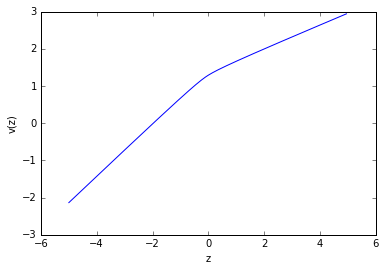

In [13]:
plt.plot(z,v)
plt.ylabel('v(z)')
plt.xlabel('z')

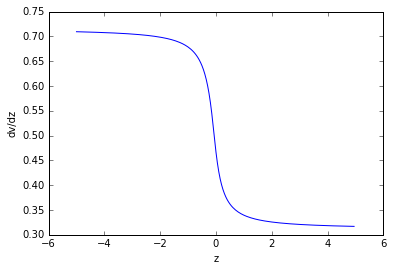

In [14]:
plt.plot(z,v1)
plt.ylabel('dv/dz')
plt.xlabel('z')

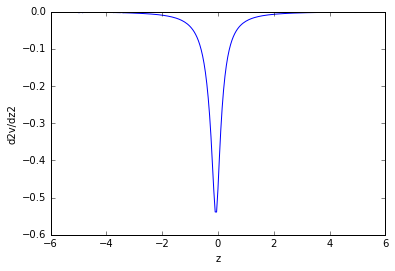

In [15]:
plt.plot(z,v2)
plt.ylabel('d2v/dz2')
plt.xlabel('z')

In [16]:
iteration

48010